# **V5 on Real Datatest**

In [1]:
import sys
import os
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))

from utils.wrapper import YOLOAPIWrappper
from utils.pipeline import CPPipeline

### **Multiplicative**

In [2]:
v5 = '../utils/v5/bestv5.onnx'
yolov5_detector_real = YOLOAPIWrappper(v5,file_path='../calibration/calibv5_real_m.pickle', conf_thres=0.7, iou_thres=0.5)
pipev5_real = CPPipeline(yolov5_detector_real, test_set='test_real', method='multiplicative')

In [3]:
X_train, y_train, labels_train= pipev5_real.extract_yolo_dataset()
X_train, X_val, y_train, y_val, labels_train, labels_val = pipev5_real.calibration_and_val(X_train, y_train, labels_train)

In [4]:
conformal_predictor = pipev5_real.pipeline( X_train=X_train, y_train= y_train, labels_train= labels_train)

Predictions: [[2681.36669922  339.078125   3580.49121094  925.10131836]
 [1959.22399902 1108.53881836 2179.04296875 1257.80957031]
 [2150.56225586  766.13793945 2217.65844727  870.00146484]
 [2588.98364258  546.79821777 2628.64428711  604.3692627 ]
 [ 814.94671631  345.05487061  839.91680908  392.47607422]
 [2353.17504883  612.41308594 2649.51098633  787.19470215]
 [1833.98291016  873.23248291 2201.04174805 1059.37854004]
 [2127.11572266  965.84686279 2274.56884766 1087.06176758]
 [1773.37402344 1128.85046387 1815.90014648 1197.01599121]
 [1503.86108398  954.77172852 1595.58837891 1049.99121094]
 [2488.65478516  680.10449219 2536.97949219  750.08740234]
 [1735.45715332  927.98016357 1872.49890137 1034.96435547]
 [2196.94628906  547.94378662 2352.61132812  690.76141357]
 [2487.52709961  531.73266602 2657.49291992  662.46838379]
 [2265.65844727  644.07513428 2369.69360352  746.05767822]
 [1916.36914062  860.06774902 2231.02294922 1026.82507324]
 [2921.50732422  793.76965332 3223.84326172

Predictions: (array([[1903.3982,  891.2987, 2612.4402, 1193.2164]], dtype=float32), array([0.98148197], dtype=float32))
Marginal coverage: 1.0
Average area: 266002.96875
Confidence score : [0.98148197]


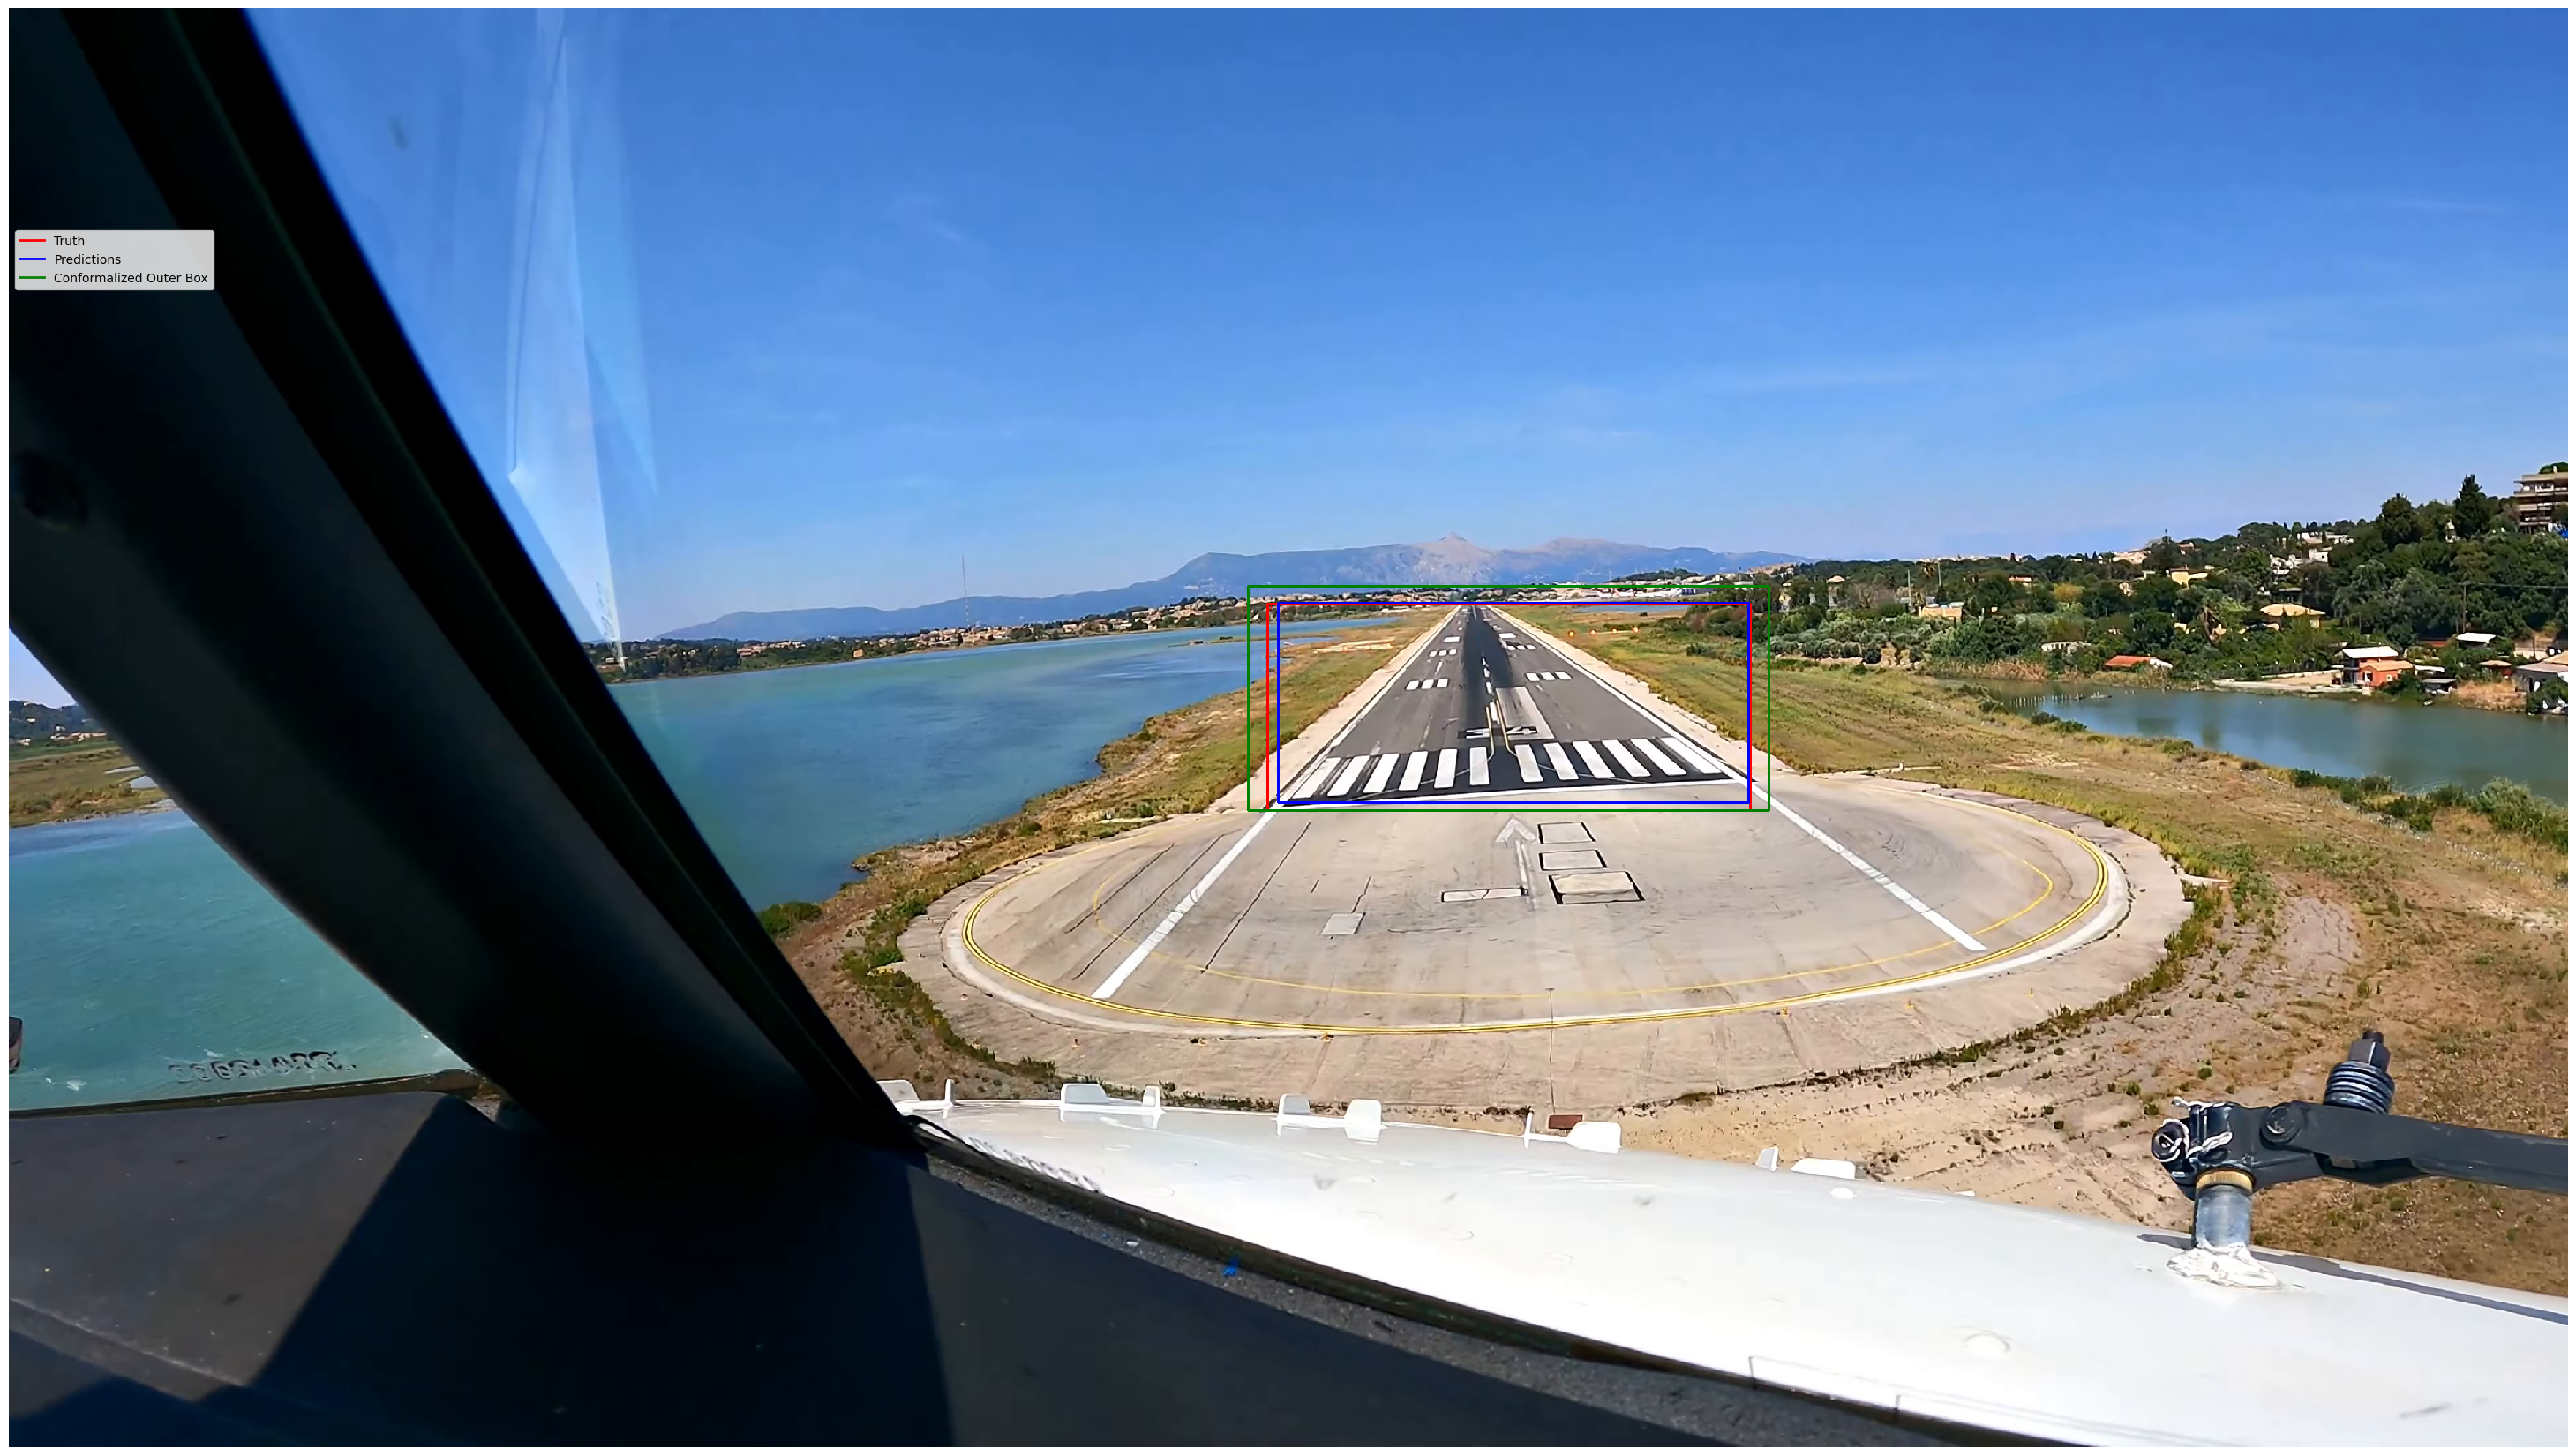

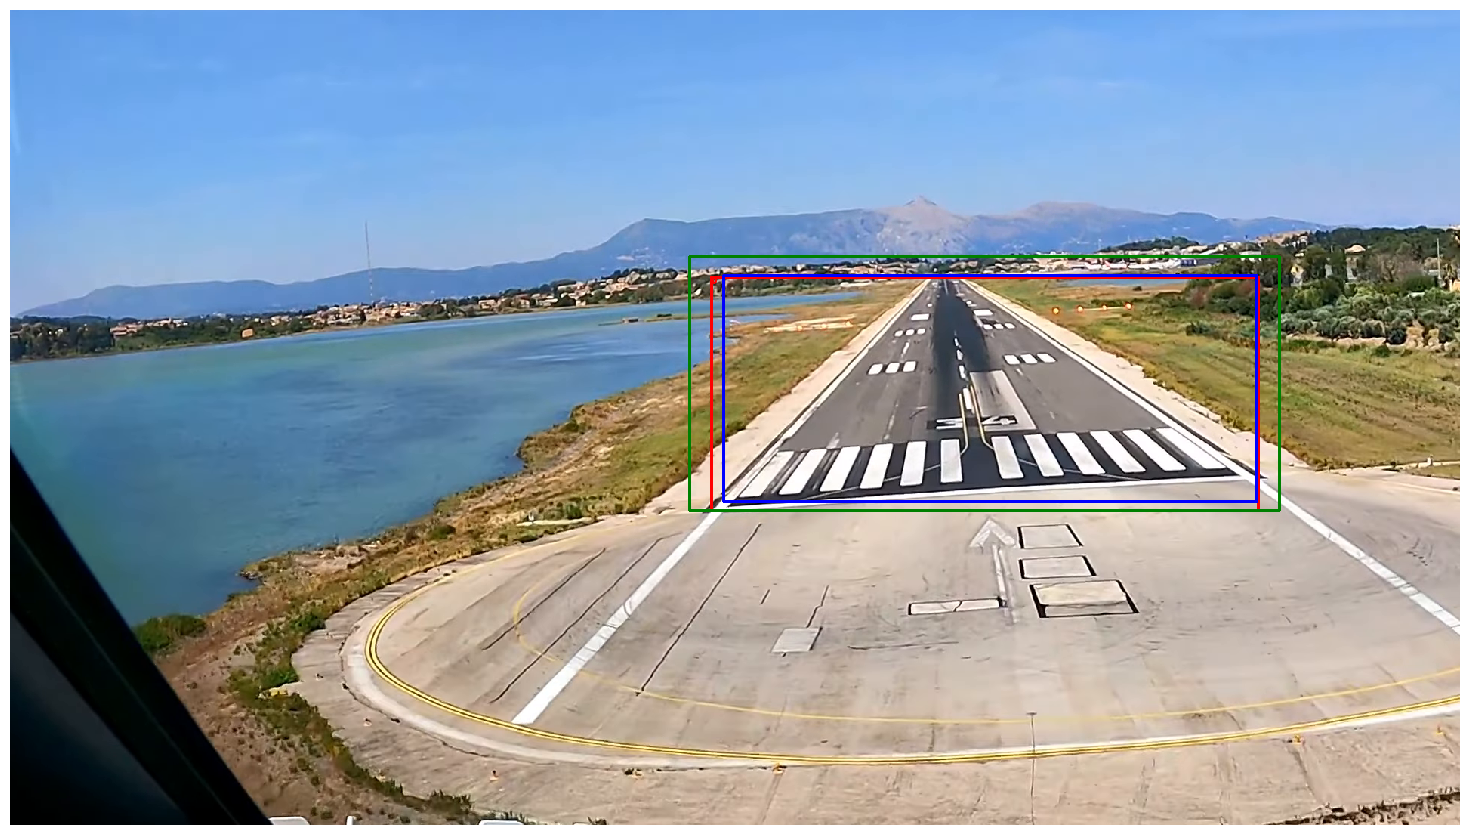

In [5]:
pipev5_real.infer_eval_single_image(
    conformal_predictor, 
    X_val[18],  # Image path at index 5
    y_val[18],  # Ground truth bounding boxes at index 5
    labels_val[18],  # Labels at index 5
    None  # `y_new_api` is set to None, so the function will compute it internally
)

In [5]:
y_pred_val, y_true_val, images_val, classes_val,score_val, box_inner_val, box_outer_val = pipev5_real.infer_all_images(conformal_predictor,X_val, y_val, labels_val, visualize = False)

Number of images: 21
Number of images without predictions: 6
Number of images with predictions: 15


In [6]:
average_glo_area, cover = pipev5_real.average_cover_and_area(y_pred_val, y_true_val, box_outer_val)

Average area of prediction intervals: 71702.75
Average length of prediction intervals: 267.773681640625
Average Marginal coverage: 0.5714285714285714


In [7]:
import os
import pandas as pd
from utils.helpers import iou, ioa

filenames = []
all_preds = []
all_trues = []
all_classes = []
iou_pred_c_gt = []
ioa_pred_c_gt = []
iou_pred_gt = []
ioa_pred_gt = []
score = []
box_inner = []
box_outer = []
all_cover = []
glo_area = []


for y_pred_, y_true_, img_path_, clss_, score_, box_inner_, box_outer_, cover_, avg_area_ in zip(y_pred_val, y_true_val, X_val, classes_val, score_val, box_inner_val, box_outer_val, cover, average_glo_area):


    filenames.append(os.path.basename(img_path_))
    all_preds.append(y_pred_)
    all_trues.append(y_true_)
    all_classes.append(clss_)
    iou_pred_c_gt.append(iou(box_outer_.flatten(), y_true_.flatten())) # iou between outer box and gt
    ioa_pred_c_gt.append(ioa(box_outer_.flatten(), y_true_.flatten())) # ioa between outer box and gt
    iou_pred_gt.append(iou(y_pred_.flatten(), y_true_.flatten()))   # iou between yolo pred and gt
    ioa_pred_gt.append(ioa(y_pred_.flatten(), y_true_.flatten()))  # ioa between yolo pred and gt
    score.append(score_) # confidence score
    box_inner.append(box_inner_)
    box_outer.append(box_outer_)
    all_cover.append(cover_) #cover between conformal box and gt
    glo_area.append(avg_area_)

df = pd.DataFrame({
    'filename': filenames,
    'pred_yolo': all_preds,
    'gt': all_trues,
    'class': all_classes,
    'iou_pred_c_gt': iou_pred_c_gt,
    'ioa_pred_c_gt': ioa_pred_c_gt,
    'iou_pred_gt': iou_pred_gt,
    'ioa_pred_gt': ioa_pred_gt,
    'score': score,
    'box_inner': box_inner,
    'box_outer': box_outer,
    'cover': cover,
    'avg_area': glo_area
})

all = pd.read_csv("/home/aws_install/conformal_runway_detection/surrogate/all_test_with_real.csv")

all_subset = all[['filename', 'slant_distance', 'time_to_landing']]

df = pd.merge(df, all_subset, on='filename', how='outer')

df.to_csv('results_v5_real_m.csv', index=False)